In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


## Load dataset

In [60]:
# Load both datasets
fake_df = pd.read_csv("data/Fake.csv")
true_df = pd.read_csv("data/True.csv")

# Add a label column
fake_df["label"] = 0  # fake
true_df["label"] = 1  # true

# Combine them
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Quick look
df.head()


,title,text,subject,date,label
0,Republicans Had Total Control Of This State A...,Bobby Jindal abandoned his home state of Louis...,News,"March 4, 2016",0
1,"Congratulations, Republicans, You Got Played","Well, here we are. The last day of eight years...",News,"January 19, 2017",0
2,Guinea rioters burn down police buildings in m...,CONAKRY (Reuters) - Hundreds of rioters in the...,worldnews,"September 21, 2017",1
3,PA TRUMP RALLY: How Support From The Amish Com...,Maybe it s the commonality they share with Tru...,politics,"Aug 16, 2016",0
4,Trump meets Irish PM at White House ahead of S...,(Reuters) - Irish Prime Minister Enda Kenny pr...,politicsNews,"March 16, 2017",1


# 🔍 Check for missing data

In [61]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [62]:
df['original_text'] = df['title'] + " " + df['text']


# Text Preprocessing Function

In [63]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    return text

In [64]:
df['cleaned_text'] = df['original_text'].apply(clean_text)


In [65]:
# Apply Cleaning
df['text'] = df['title'] + " " + df['text']  # Combine title and body
df['text'] = df['text'].apply(clean_text)

# Final preview
df[['text', 'label']].head()


,text,label
0,republicans had total control of this state a...,0
1,congratulations republicans you got played we...,0
2,guinea rioters burn down police buildings in m...,1
3,pa trump rally how support from the amish comm...,0
4,trump meets irish pm at white house ahead of s...,1


In [66]:
df[['original_text', 'cleaned_text']].head(10)


,original_text,cleaned_text
0,Republicans Had Total Control Of This State A...,republicans had total control of this state a...
1,"Congratulations, Republicans, You Got Played ...",congratulations republicans you got played we...
2,Guinea rioters burn down police buildings in m...,guinea rioters burn down police buildings in m...
3,PA TRUMP RALLY: How Support From The Amish Com...,pa trump rally how support from the amish comm...
4,Trump meets Irish PM at White House ahead of S...,trump meets irish pm at white house ahead of s...
5,"Putin, as part of test, oversees launch of fou...",putin as part of test oversees launch of four ...
6,Kenya court awards 4 million shillings to girl...,kenya court awards million shillings to girl ...
7,WATCH OBAMA Admit To Rigged Elections In 2008:...,watch obama admit to rigged elections in “whe...
8,WATCH: CNN Host Destroys Trump Campaign Manag...,watch cnn host destroys trump campaign manage...
9,Trump Just Praised Fox News’ Ratings And Atta...,trump just praised fox news’ ratings and atta...


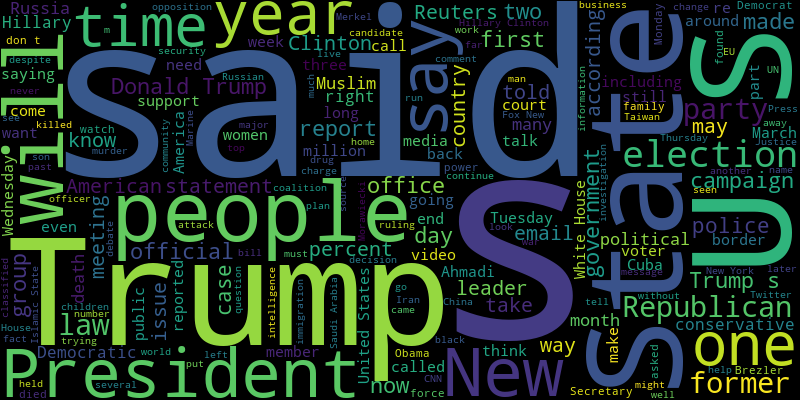

In [67]:
from wordcloud import WordCloud

# Before cleaning
WordCloud(width=800, height=400).generate(" ".join(df['original_text'][:100])).to_image()

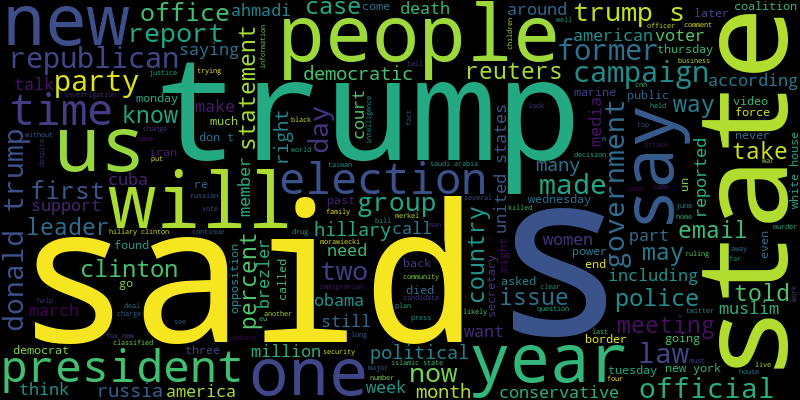

In [68]:
# After cleaning
WordCloud(width=800, height=400).generate(" ".join(df['cleaned_text'][:100])).to_image()

In [69]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 209


In [70]:
# 🧹 Remove duplicates
df = df.drop_duplicates()

In [71]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


# 📤 Split the data

In [72]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🔠 TF-IDF Vectorization

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [74]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, vectorizer.transform(X), y, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())


Cross-validation accuracy scores: [0.99474155 0.99541284 0.99563661 0.99541284 0.99418149]
Mean CV accuracy: 0.9950770682813308


# 🤖 Train the Model

In [75]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = PassiveAggressiveClassifier(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)


# 📊 Evaluate the Model

Accuracy: 0.994182143656299

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4730
           1       1.00      0.99      0.99      4208

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



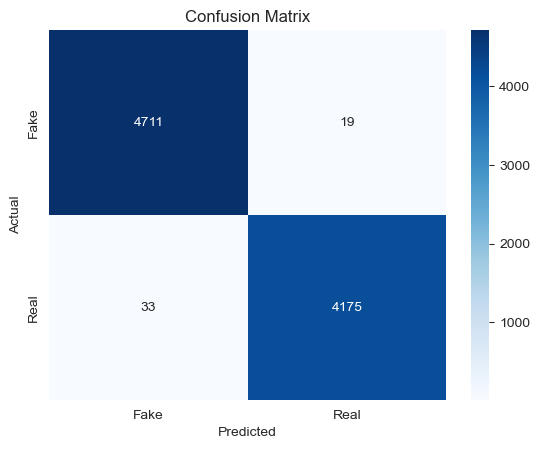

In [76]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [78]:
from matplotlib.pyplot import clf


def predict_user_input(text):
    # Transform the text using your trained TF-IDF vectorizer
    text_tfidf = vectorizer.transform([text])
    # Predict using your trained classifier
    prediction = model.predict(text_tfidf)[0]
    # Convert label to readable string
    label = "Fake News" if prediction == 0 else "Real News"
    return label

# Example interactive test
while True:
    user_text = input("Enter news text (or type 'exit' to quit):\n")
    if user_text.lower() == "exit":
        break
    result = predict_user_input(user_text)
    print(f"Prediction: {result}\n")


Prediction: Fake News

Prediction: Fake News



KeyboardInterrupt: Interrupted by user

As can be ssen before our classical model does not predict accuratly as classical models like PassiveAggressiveClassifier with TF-IDF are great for simple patterns but struggle with sentences or topics they haven’t seen before — they lack true understanding of language context.

In [79]:
from transformers import pipeline

classifier = pipeline("text-classification", model="mrm8488/bert-tiny-finetuned-fake-news-detection")

def predict(text):
    result = classifier(text)[0]
    return f"{result['label']} (score: {result['score']:.2f})"

print(predict("Some news text here"))


/Users/oumaymabamoh/miniconda3/envs/Fake_News_AI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [ ]:
from transformers import pipeline
from sklearn.model_selection import train_test_split

# Split your data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Convert labels to strings because transformers use text labels
y_train_str = y_train.map({0: "FAKE", 1: "REAL"})
y_test_str = y_test.map({0: "FAKE", 1: "REAL"})

# Save to files (BERT pipeline expects files or HuggingFace datasets)
train_data = [{'text': t, 'label': l} for t, l in zip(X_train, y_train_str)]
test_data = [{'text': t, 'label': l} for t, l in zip(X_test, y_test_str)]
